In [1]:
import numpy as np
import xesmf as xe
import xarray as xr
import matplotlib.pyplot as plt
xe.__version__

'0.8.10'

In [2]:
import esmpy
esmpy.__version__

'8.8.1'

In [3]:
# 2-degree lat-lon grid
ds_in  = xe.util.grid_global(2, 2, lon1=360)

# 1-degree lat-lon grid
ds_out = xe.util.grid_global(1, 1, lon1=360)

In [4]:
# 2D lon/lat
lon2d = ds_in['lon']
lat2d = ds_in['lat']

def gaussian(ampl, λ0, φ0, width):
    # Gaussian field
    return xr.DataArray(
        ampl * np.exp(-((lon2d - λ0)**2 + (lat2d - φ0)**2) / (2 * width**2)),
        dims=('y', 'x'),
        coords={'lon': lon2d, 'lat': lat2d},
        name="gaussian_field"
    )

# pick a center and width
λ0, φ0 = 150, 30   # center
width = 12         # degrees

data_in = gaussian(1, 150, 30, width) + gaussian(-2, 270, -20, width)
data_in

<xarray.DataArray 'gaussian_field' (y: 90, x: 180)> Size: 130kB
array([[ 1.46996071e-55,  1.14821221e-54,  8.72318053e-54, ...,
        -1.68476030e-18, -5.10267008e-19, -1.50311816e-19],
       [ 7.56948141e-55,  5.91265531e-54,  4.49195360e-53, ...,
        -4.33216641e-18, -1.31209264e-18, -3.86509465e-19],
       [ 3.79107863e-54,  2.96127832e-53,  2.24973791e-52, ...,
        -1.08344883e-17, -3.28146499e-18, -9.66636986e-19],
       ...,
       [ 9.12064795e-39,  7.12429883e-38,  5.41246159e-37, ...,
        -6.03438672e-28, -1.82764780e-28, -5.38379037e-29],
       [ 4.19026120e-39,  3.27308686e-38,  2.48662462e-37, ...,
        -1.38437947e-28, -4.19290015e-29, -1.23512284e-29],
       [ 1.87237470e-39,  1.46254487e-38,  1.11112239e-37, ...,
        -3.08896814e-29, -9.35562483e-30, -2.75593158e-30]],
      shape=(90, 180))
Coordinates:
    lon      (y, x) float64 130kB 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
    lat      (y, x) float64 130kB -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0
Dimensions without coordinates: y, x

In [5]:
regridder = xe.Regridder(ds_in, ds_out, "conservative", periodic=True)

In [6]:
data_out = regridder(data_in)
data_out

<xarray.DataArray (y: 180, x: 360)> Size: 518kB
array([[ 1.46996071e-55,  1.46996071e-55,  1.14821221e-54, ...,
        -5.10267008e-19, -1.50311816e-19, -1.50311816e-19],
       [ 1.47119826e-55,  1.47119826e-55,  1.14917888e-54, ...,
        -5.10429692e-19, -1.50359739e-19, -1.50359739e-19],
       [ 7.56948141e-55,  7.56948141e-55,  5.91265531e-54, ...,
        -1.31209264e-18, -3.86509465e-19, -3.86509465e-19],
       ...,
       [ 4.19026120e-39,  4.19026120e-39,  3.27308686e-38, ...,
        -4.19290015e-29, -1.23512284e-29, -1.23512284e-29],
       [ 1.87284498e-39,  1.87284498e-39,  1.46291221e-38, ...,
        -9.36223373e-30, -2.75787839e-30, -2.75787839e-30],
       [ 1.87237470e-39,  1.87237470e-39,  1.46254487e-38, ...,
        -9.35562483e-30, -2.75593158e-30, -2.75593158e-30]],
      shape=(180, 360))
Coordinates:
    lon      (y, x) float64 518kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lat      (y, x) float64 518kB -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  conservative

<Figure size 640x480 with 0 Axes>

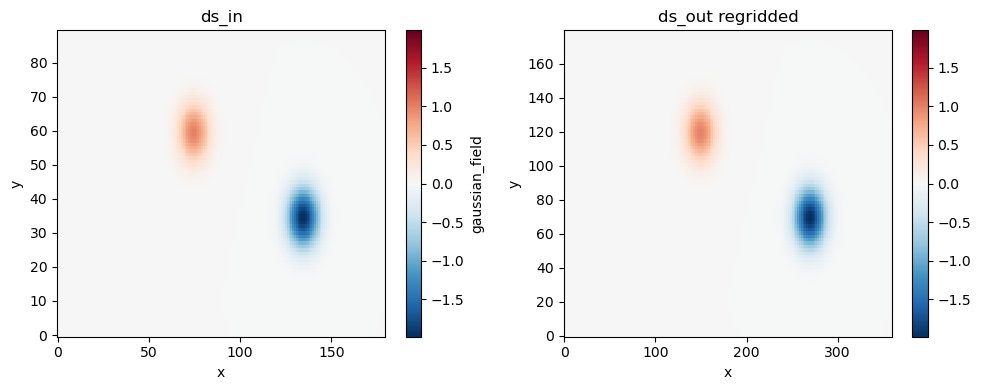

In [7]:
plt.figure()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

data_in.plot(ax = axes[0])
axes[0].set_title("ds_in")

data_out.plot(ax = axes[1])
axes[1].set_title("ds_out regridded")

plt.tight_layout();

In [8]:
def compute_integral(data, ds, R_earth):

    lon_b = np.deg2rad(ds['lon_b'].values)
    lat_b = np.deg2rad(ds['lat_b'].values)
    area = np.zeros((ds.sizes['y'], ds.sizes['x']))
    for j in range(ds.sizes['y']):
        for i in range(ds.sizes['x']):
            dlon = lon_b[j, i+1] - lon_b[j, i]
            dlat = np.sin(lat_b[j+1, i]) - np.sin(lat_b[j, i])
            area[j, i] = R_earth**2 * dlon * dlat

    return np.sum(data.values * area)

In [9]:
R_earth = 6.371e6

# test that compute_integral works;
# gives ones as input and check if it gives the area of Earth

print(compute_integral(xr.ones_like(data_in, dtype=float), ds_in, R_earth)   - 4*np.pi*R_earth**2)
print(compute_integral(xr.ones_like(data_out, dtype=float), ds_out, R_earth) - 4*np.pi*R_earth**2)
print(compute_integral(xr.ones_like(data_in, dtype=float), ds_in, R_earth))
print(compute_integral(xr.ones_like(data_out, dtype=float), ds_out, R_earth))

0.0
0.0
510064471909788.25
510064471909788.25


In [10]:
integral_in = compute_integral(data_in, ds_in, R_earth)
integral_out = compute_integral(data_out, ds_out, R_earth)

In [11]:
print("integral ds_in : ", integral_in)
print("integral ds_out: ", integral_out)

print("abs error: ", np.abs(integral_in - integral_out))
print("rel error: ", np.abs(integral_in - integral_out) / np.abs(integral_in))

integral ds_in :  -11089929769375.488
integral ds_out:  -11090665232069.717
abs error:  735462694.2285156
rel error:  6.631806598626747e-05
